# Hands on tutorial: Introduction to Anomaly Detection on HEP dataset


This notebook trains a basic DNN-based Anutoencoder model using the ADC2021 Challenge data. 

**Many thanks to Vinicius Mikuni for helping with the notebook**

In [1]:
#Choose the ATLAS ML kernel from the dropdown menu!
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import sys
sys.path.insert(0, '../scripts/')

2022-09-27 06:05:28.974691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [2]:
from func import load_model, save_model, SetStyle
SetStyle()

## Load background dataset

We will use the dataset provided by the ADC2021 Challenge
https://mpp-hep.github.io/ADC2021/

We consider the following Standard Model (SM) processes, with their relative contribution to the dataset listed in
parenthesis:
 - Inclusive W boson production, where the W boson decays to a charged lepton ($\ell$) and a neutrino ($\nu$), (59.2% of the dataset). The lepton could be a $e, \mu,$ or $\tau$ lepton.
 - Inclusive $Z$ boson production, with $Z \to \ell \ell ~(e, \mu, \tau)$ (6.7% of the dataset),
 - $t \bar{t}$ production (0.3% of the dataset), and
 - QCD multijet production (33.8% of the dataset)

In [4]:
dataset_folder = "/eos/atlas/atlascerngroupdisk/phys-exotics/hqt/mltutorial2022/"
#Be sure to run first if you want to make your own files
# python create_datasets.py --bkg_file background_for_training.h5 --output_bkg_name 'BKG' --signals_files 'Ato4l_lepFilter_13TeV.h5' --output_signal_names 'Ato4l_lepFilter_13TeV' --events=1000000
filename = 'BKG_dataset.h5'

In [5]:
# Reading the background training data
with h5py.File(dataset_folder+filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])
    

print("Shape of X_train: ", X_train.shape)



Shape of X_train:  (640000, 57)


## Training Data Information

- Each event contains information about 19 objects: MET, 4 electrons, 4 muons, 10 jets
- Three features are stored describing each physics object: (pT, eta, phi)

### Input features 19 x 3  = 57

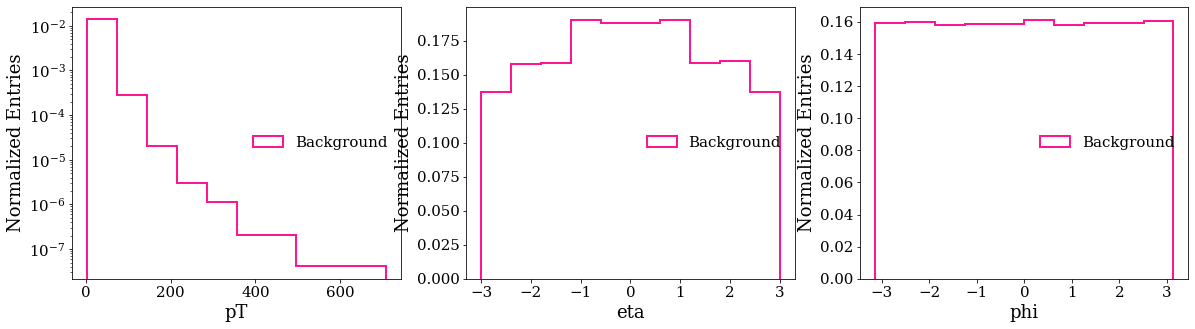

In [6]:
#Let's plot some histograms
plt.figure(figsize=(20,5))
logy_dict = {'pT':True,'eta':False,'phi':False}
for i,name in enumerate(logy_dict):
    plt.subplot(1,3,i+1)
    to_plot=X_train[:,3+i]
    to_plot=to_plot[to_plot!=0]
    plt.hist(to_plot.flatten(),label="Background", density = True, histtype='step', fill=False, linewidth=2, color="deeppink")
    if logy_dict[name]:plt.yscale('log')
    plt.xlabel(name)
    plt.ylabel("Normalized Entries")
    plt.legend(loc='center right')


## Let's build an autoencoder with fully-connected layers <img src="../assets/autoencoder.png" width=400 height=400 />


In [8]:
# Input shape is 57
# 
input_shape = 57
latent_dimension = 8
num_nodes=[32,16]


In [9]:
#encoder
inputArray = layers.Input(shape=(input_shape))
x = layers.Dense(num_nodes[0], use_bias=False,activation='relu')(inputArray)
x = layers.Dense(num_nodes[1], use_bias=False,activation='relu')(x)
encoder = layers.Dense(latent_dimension, use_bias=False,activation='relu')(x)

#decoder
x = layers.Dense(num_nodes[1], use_bias=False,activation='relu')(encoder)
x = layers.Dense(num_nodes[0], use_bias=False,activation='relu')(x)
decoder = layers.Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 32)                1824      
                                                                 
 dense_1 (Dense)             (None, 16)                512       
                                                                 
 dense_2 (Dense)             (None, 8)                 128       
                                                                 
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                512       
                                                                 
 dense_5 (Dense)             (None, 57)                1881  

2022-09-27 06:08:16.653460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_fo

In [10]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Trainining and saving the model

In [11]:
EPOCHS = 50
BATCH_SIZE = 10000

In [12]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

2022-09-27 06:08:47.358458: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145920000 exceeds 10% of free system memory.
2022-09-27 06:08:48.341885: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145920000 exceeds 10% of free system memory.


Epoch 1/50
64/64 [==============================] - 4s 46ms/step - loss: 81.0166 - val_loss: 48.6668
Epoch 2/50
64/64 [==============================] - 2s 29ms/step - loss: 23.2763 - val_loss: 10.8956
Epoch 3/50
64/64 [==============================] - 2s 30ms/step - loss: 7.3986 - val_loss: 5.5304
Epoch 4/50
64/64 [==============================] - 2s 26ms/step - loss: 4.3123 - val_loss: 3.2049
Epoch 5/50
64/64 [==============================] - 2s 27ms/step - loss: 2.5099 - val_loss: 1.8329
Epoch 6/50
64/64 [==============================] - 2s 27ms/step - loss: 1.3387 - val_loss: 1.0333
Epoch 7/50
64/64 [==============================] - 2s 27ms/step - loss: 0.9395 - val_loss: 0.8770
Epoch 8/50
64/64 [==============================] - 1s 22ms/step - loss: 0.8448 - val_loss: 0.8228
Epoch 9/50
64/64 [==============================] - 2s 24ms/step - loss: 0.8095 - val_loss: 0.7964
Epoch 10/50
64/64 [==============================] - 2s 27ms/step - loss: 0.7852 - val_loss: 0.7734
Epoch

In [13]:
model_name = 'DNN_AE'
model_directory = 'DNNS/'
if not os.path.exists(model_directory+model_name):
    os.makedirs(model_directory+model_name)
save_model(model_directory+model_name, autoencoder)

## Let's take a look at the reconstruction for the background

In [14]:
bkg_prediction = autoencoder.predict(X_test,batch_size=1000)

2022-09-27 06:10:28.317674: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45600000 exceeds 10% of free system memory.
2022-09-27 06:10:28.888333: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45600000 exceeds 10% of free system memory.


## Now let's take a look at the signals! <img src="../assets/NP.png" width=800 height=200 />

In [15]:
# add correct signal labels: defined within the h5 file created by the data processing script
signal_labels = ['A to 4 leptons',
                 'h to tau tau',
                 'leptoquark',
                 'charged h to tau nu']
# add correct path to signal files
signals_file = ['Ato4l_lepFilter_13TeV_dataset.h5',
                'hToTauTau_13TeV_PU20_dataset.h5',
                'leptoquark_LOWMASS_lepFilter_13TeV_dataset.h5',
                'hChToTauNu_13TeV_PU20_dataset.h5']

In [16]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(dataset_folder+signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data[:, :])

In [17]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i],batch_size=1000)
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

2022-09-27 06:11:47.565747: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 157612524 exceeds 10% of free system memory.


## Before looking into the results, let's save the trained model in case we want to use it again

In [18]:
save_file = 'dnn_results'

In [19]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

# Evaluating the autoencoder

## Let's take a look at the reconstruction error for the different signals and background

In [20]:
from func import mse_loss

In [21]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction)) #first put the loss on the background test sample
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]))

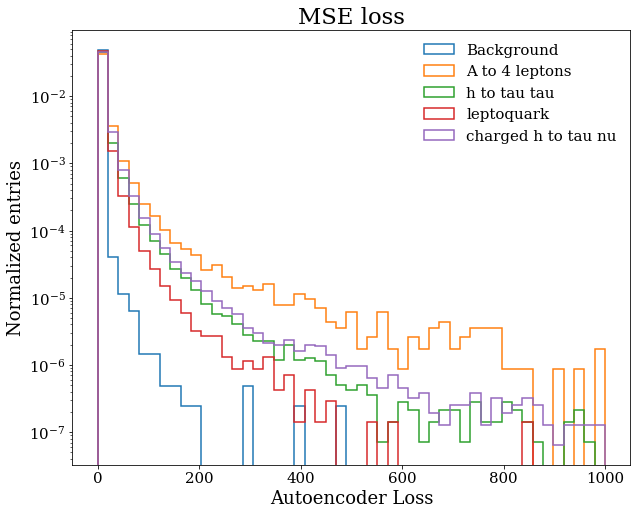

In [22]:
binning=np.linspace(0,1000,50)

plt.figure(figsize=(10,8))
plt.hist(total_loss[0], bins=binning, label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i+1], bins=binning, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Normalized entries")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

## Let's now make a Receiver Operating Characteristic (ROC) curve

In [23]:
from sklearn.metrics import roc_curve, auc

In [24]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

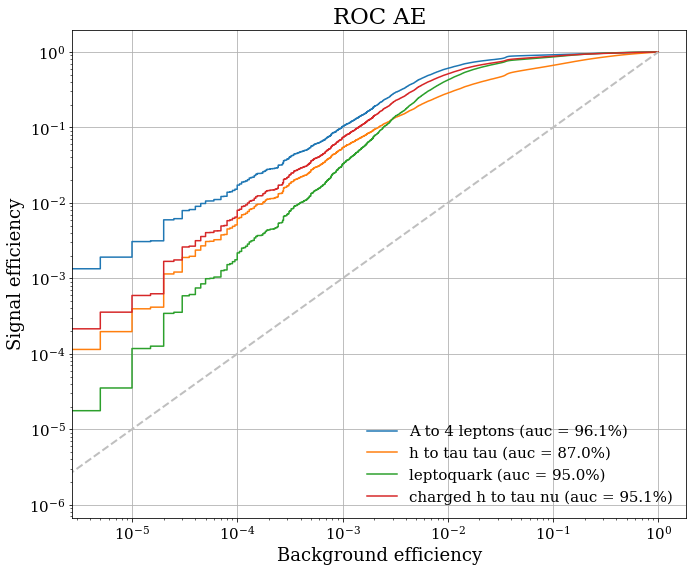

In [28]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("Signal efficiency")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.title("ROC AE")
plt.show()

## Let's now make a Significance Improvement (SIC) curve

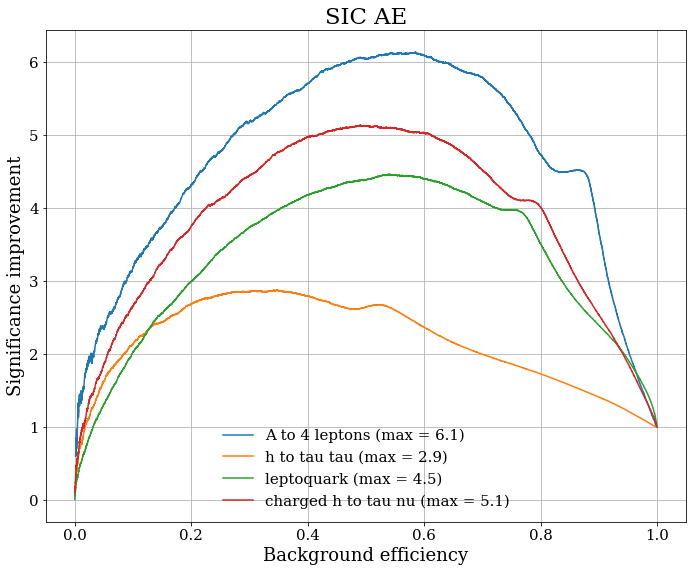

In [26]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)    
    plt.plot(tpr_loss,np.ma.divide(tpr_loss,np.sqrt(fpr_loss)), "-", label='%s (max = %.1f)'%(label,np.max(np.ma.divide(tpr_loss,np.sqrt(fpr_loss)))), linewidth=1.5)
    

    plt.ylabel("Significance improvement")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.title("SIC AE")
plt.show()